In [19]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm

In [9]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

training_data = [
    # Targs are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        
        if word not in word_to_ix: # this check if the word has not beed assigned an index yet
            word_to_ix[word] = len(word_to_ix) # this will assign each word with a unique index
            
print(word_to_ix)

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [10]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2} # assign each tag to a unique index as well

# these will usually be more like 32 or 64 dimensional
# we will keep them small, so we can see how the weights change as we train
INPUT_DIM = 6

In [11]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_dim, vocab_size, tagset_size):
        
        super(LSTMModel, self).__init__()
        
        # word embedding
        self.word_embeddings = nn.Embedding(vocab_size, input_dim)
        
        # lstm layers
        self.lstm = nn.Sequential(
            nn.LSTM(input_dim, 80, batch_first=True),
            nn.LSTM(80, 40, batch_first=True),
            nn.LSTM(40, 40, batch_first=True),
            nn.LSTM(40, 20, batch_first=True)
        )
        
        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, tagset_size)
        )

    def forward(self, x):
        
        # convert sentence into embeddings
        x = self.word_embeddings(x)
        x = x.view(len(x), 1, -1)
        
        # pass through lstm layers
        for lstm_layer in self.lstm:
            x, _ = lstm_layer(x)
        
        # fc layers
        x = self.fc_layers(x.view(len(x), -1)) # sequence-to-sequence task
        
        # apply softmax
        x = F.log_softmax(x, dim=1)
        
        return x

In [12]:
model = LSTMModel(INPUT_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [21]:
loss_step = []

In [40]:
for epoch in tqdm(range(500)): # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # step 1: remember that pytorch accumulates gradients
        # we need to clear them out before each instance
        model.zero_grad()
        
        # step 2: get inputs ready for the network
        # turn them into tensors of word indices
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        
        # step 3: run forward pass
        tag_scores = model(sentence_in)
        
        # step 4: compute the loss, gradients and update parameters
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        
        loss_step.append(loss)

100%|██████████| 500/500 [00:09<00:00, 51.94it/s]


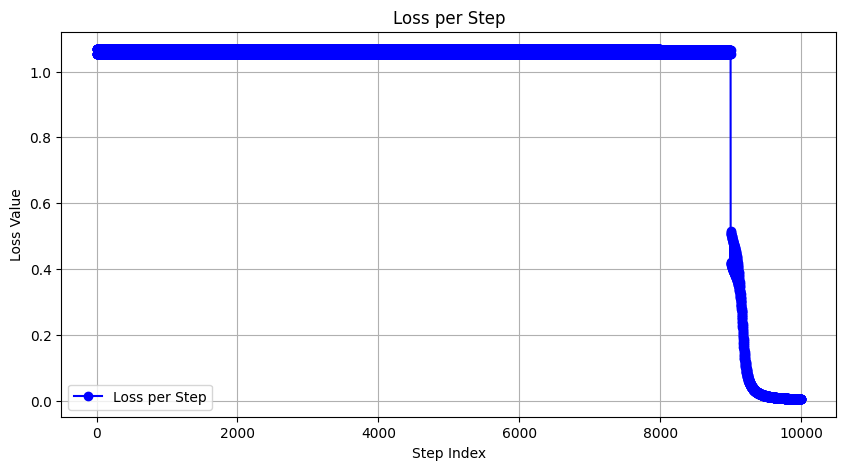

In [48]:
for i in range(len(loss_step)):
    if type(loss_step[i]) is torch.Tensor:
        loss_step[i] = loss_step[i].detach().item()

plt.figure(figsize=(10, 5))
plt.plot(loss_step, marker='o', linestyle='-', color='b', label='Loss per Step')
plt.xlabel('Step Index')
plt.ylabel('Loss Value')
plt.title('Loss per Step')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
print(f"Loss: {loss}")

Loss: 1.053666353225708


In [18]:
# see scores after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    
    # the sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

tensor([[-1.1288, -0.7958, -1.4901],
        [-1.1290, -0.7957, -1.4900],
        [-1.1290, -0.7957, -1.4899],
        [-1.1288, -0.7958, -1.4900],
        [-1.1290, -0.7957, -1.4900]])
